We've had a look at what outputs we get when we feed in random data.

Now let's see what we get with some real world data.

We can generate an input_data generator that yields a flattened downsampled set of low-resolution pixel values.

See - https://github.com/benhoyle/predictive_coding/blob/master/Building%20AV%20Capture%20Objects.ipynb.

In [1]:
from src.sources.capture import VideoSource

def frame():
    """Generate a 1D array from a video signal."""
    video = VideoSource()
    video.start()
    while True:
        # Get a frame from the video
        yield video.read()[1][:, :, 1]

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

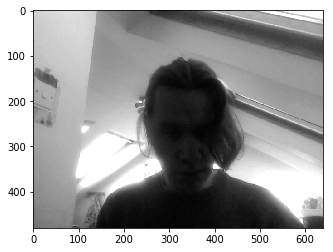

In [4]:
plt.imshow(video.read()[1][:, :, 1], cmap="gray")

In [5]:
video.read()[1].shape

(480, 640, 3)

In [7]:
import cv2
import math

def reduce_to_2(image, reduce="centre"):
    """Reduce image size to a square that is a factor of 2."""
    rows, cols = image.shape
    smallest = min((rows, cols))
    scales = int(math.log2(rows))
    size = 2**scales
    row_diff = rows - size
    col_diff = cols - size
    # Watch out for when array is well-formed
    upper_row = rows
    lower_row = 0
    upper_col = cols
    lower_col = 0
    if row_diff:
        upper_row = -row_diff//2
        lower_row = row_diff//2
    if col_diff:
        # This is needed when processing left/right visual fields
        if reduce == "centre":
            # Crop either side of the centre
            upper_col = -col_diff//2
            lower_col = col_diff//2
        elif reduce == "left":
            # Crop from the left
            lower_col = col_diff
        elif reduce == "right":
            # Crop from the right
            upper_col = -col_diff
    return image[lower_row:upper_row, lower_col:upper_col]

def create_pyramid(image, reduce="centre"):
    """Create a gaussian image pyramid from the image."""
    #image = reduce_to_2(image, reduce)
    rows, cols = image.shape
    scales = rows.bit_length()-1
    # Create list to hold scales
    pyramid = [image]
    current_image = image
    for i in range(scales):
        rows, cols = current_image.shape
        lower_level = cv2.pyrDown(
            current_image,
            (rows//2, cols//2)
        )
        # Save downsampled array in pyramid
        pyramid.append(lower_level)
        current_image = lower_level
    return pyramid

In [8]:
image = video.read()[1][:, :, 1]

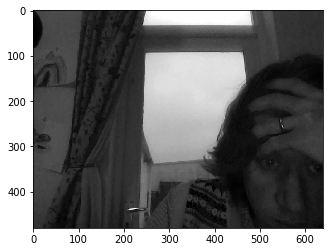

In [9]:
plt.imshow(image, cmap="gray")

In [10]:
image[0, :]

array([ 22,  25,  39,  56,  59,  63,  65,  65,  72,  72,  68,  71,  67,
        68,  74,  74,  74,  74,  72,  76,  76,  73,  65,  65,  74,  73,
        71,  73,  74,  74,  74,  74,  75,  74,  70,  70,  71,  73,  78,
        76,  79,  79,  72,  72,  77,  77,  76,  76,  76,  75,  76,  76,
        76,  76,  77,  76,  72,  72,  75,  77,  76,  76,  77,  77,  73,
        73,  75,  76,  78,  78,  75,  75,  78,  78,  80,  80,  79,  79,
        75,  74,  71,  72,  74,  72,  70,  72,  79,  79,  78,  77,  75,
        74,  73,  75,  76,  77,  76,  76,  73,  73,  67,  66,  71,  70,
        73,  72,  68,  68,  64,  60,  50,  39,  38,  38,  39,  39,  43,
        43,  37,  37,  50,  50,  35,  28,  16,  24,  32,  32,  30,  27,
        20,  24,  27,  28,  28,  28,  32,  29,  31,  28,  30,  30,  31,
        33,  42,  44,  44,  43,  42,  40,  33,  28,  25,  21,  19,  18,
        18,  20,  19,  17,  22,  22,  19,  17,  19,  25,  23,  28,  38,
        43,  47,  48,  42,  39,  37,  37,  37,  37,  34,  34,  3

In [11]:
pyramid = create_pyramid(image)

In [12]:
pyramid

[array([[22, 25, 39, ..., 42, 41, 40],
        [21, 23, 32, ..., 44, 41, 40],
        [18, 18, 25, ..., 44, 42, 42],
        ...,
        [53, 53, 53, ...,  6,  6,  6],
        [54, 53, 55, ...,  6,  6,  6],
        [52, 52, 54, ...,  6,  6,  6]], dtype=uint8),
 array([[24, 36, 57, ..., 44, 43, 42],
        [19, 27, 46, ..., 45, 45, 43],
        [15, 17, 26, ..., 48, 48, 46],
        ...,
        [55, 54, 52, ..., 10,  8,  6],
        [53, 53, 51, ...,  7,  7,  6],
        [53, 54, 53, ...,  6,  6,  6]], dtype=uint8),
 array([[28, 46, 66, ..., 48, 47, 44],
        [20, 32, 56, ..., 49, 47, 47],
        [15, 18, 34, ..., 48, 47, 48],
        ...,
        [53, 54, 52, ..., 17, 17, 14],
        [54, 53, 52, ..., 16, 14, 10],
        [53, 52, 51, ..., 14, 10,  7]], dtype=uint8),
 array([[33, 53, 69, ..., 49, 50, 47],
        [21, 38, 64, ..., 49, 50, 48],
        [10, 18, 49, ..., 49, 49, 48],
        ...,
        [54, 54, 54, ..., 21, 21, 19],
        [54, 53, 52, ..., 21, 19, 17],
      

In [13]:
pyramid[-2].flatten().shape

(20,)

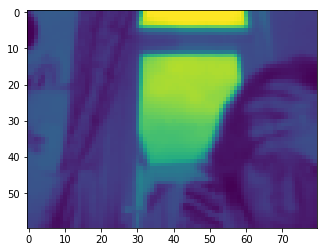

In [14]:
plt.imshow(pyramid[3])

We need to get a video stream, downsample, convert to binary then pass to our VPU visualiser.

In [35]:
from src.var_processor.pb_threshold import pb_threshold

def video_stream():
    """Generate a 1D array from a video signal."""
    while True:
        # Get a frame from the video
        image = video.read()[1][:, :, 1]
        # Create an image pyramid
        pyramid = create_pyramid(image)
        # Convert from 2d > 1D
        flat = pyramid[-2].flatten()
        # Reshape to a column vector
        flat = flat.reshape(-1, 1)
        # Threshold to binary
        yield pb_threshold(flat)

In [16]:
def video_stream_nonbin():
    """Generate a 1D array from a video signal."""
    while True:
        # Get a frame from the video
        image = video.read()[1][:, :, 1]
        # Create an image pyramid
        pyramid = create_pyramid(image)
        # Convert from 2d > 1D
        flat = pyramid[-1].flatten()
        # Reshape to a column vector
        flat = flat.reshape(-1, 1)
        # Threshold to binary
        yield flat

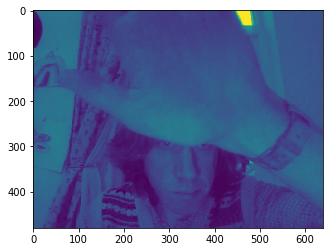

In [20]:
plt.imshow(video.read()[1][:, :, 1])

In [40]:
next(video_stream())

array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

Do we just get random vectors out of this?

Is it right to change our thresholds each iteration? Yes because otherwise we have bias. But does any pattern come through?

In [33]:
from src.visualisers.visualisers import VPUVisualizer
from src.var_processor.vpu import VPUNonLin

<IPython.core.display.Javascript object>


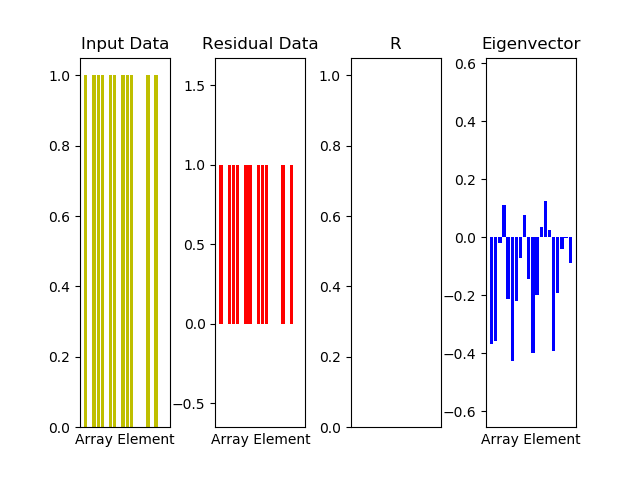

In [42]:
%matplotlib notebook
vpu = VPUNonLin(20)
visualiser = VPUVisualizer(vpu, video_stream())
visualiser.show()

Is there any pattern? It looks just like random firing...

Ah yes our video feed isn't working!

In [ ]:
update(self, "")